# JAXTAM - Just Another X-Ray Timing Module

## Walkthrough

First, import JAXTAM by calling `using JAXTAM`

In [1]:
using JAXTAM

Now, the local user configuration needs to be set up.

## Configuration

In [2]:
JAXTAM.config()

INFO: Creating config file at: /home/robert/.julia/v0.6/JAXTAM/user_configs.jld2


Dict{Any,Any} with 1 entry:
  :_config_edit_date => 2018-07-09T00:34:28.86

Add in the missions. Mission configurations are defined by a `MissionDefinition` type:


```
mutable struct MissionDefinition
    name::String
    url::String
    path::String
    path_obs::Function
    path_cl::Function
    path_uf::Function
    path_rmf::String
    good_energy_max::Number
    good_energy_min::Number
    instruments::Array
end
```

These types contain the mission `name`, an `url` to the HEASARC master table for that mission, a `path` to the local folder the data will be stored in, three path functions (`path_obs`, `path_cl`, and `path_uf`) which return the path to the relevant folders/files, given a row from the master table. Functions have to be used for this as some more complex path structures exist, like for NICER which uses the observation date for the folders. Lastly, the mission energy ranges are entered as `good_energy_min` and `good_energy_max`.

JAXTAM includes default missions, if a mission name is included in these defaults then only the local `path` is required. This speeds up adding new missions:

In [3]:
JAXTAM.config(:nicer, "/media/robert/HVS1/heasrac/nicer/")

INFO: nicer found in defaults
Using /media/robert/HVS1/heasrac/nicer/ as path


Dict{Any,Any} with 2 entries:
  :nicer             => JAXTAM.MissionDefinition("nicer", "https://heasarc.gsfc…
  :_config_edit_date => 2018-07-09T00:34:39.732

In [4]:
JAXTAM.config(:nustar, "/media/robert/HVS1/heasrac/nustar/")

INFO: nustar found in defaults
Using /media/robert/HVS1/heasrac/nustar/ as path


Dict{Any,Any} with 3 entries:
  :nicer             => JAXTAM.MissionDefinition("nicer", "https://heasarc.gsfc…
  :_config_edit_date => 2018-07-09T00:34:41.57
  :nustar            => JAXTAM.MissionDefinition("nustar", "https://heasarc.gsf…

A default mission can also be set in the configuration:

In [5]:
JAXTAM.config(:default, :nicer)

INFO: Setting default mission to nicer


Dict{Any,Any} with 4 entries:
  :nicer             => JAXTAM.MissionDefinition("nicer", "https://heasarc.gsfc…
  :default           => :nicer
  :_config_edit_date => 2018-07-09T00:34:43.265
  :nustar            => JAXTAM.MissionDefinition("nustar", "https://heasarc.gsf…

Removing missions is simple and can be done with `config_rm(mission_name`.

## Master Tables

As the url to the master table is included in the mission definitions, downloading the master tables is simple:

In [6]:
JAXTAM.master(:nicer)[1:2, :]

	/media/robert/HVS1/heasrac/nicer/master.tdat 
	/media/robert/HVS1/heasrac/nicer/master.jld2
INFO: Download master files from `https://heasarc.gsfc.nasa.gov/FTP/heasarc/dbase/tdat_files/heasarc_nicermastr.tdat.gz`? (y/n)
INFO: Downloading latest master catalog
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  360k  100  360k    0     0   238k      0  0:00:01  0:00:01 --:--:--  238k



7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=en_GB.UTF-8,Utf16=on,HugeFiles=on,4 CPUs)

Processing archive: /media/robert/HVS1/heasrac/nicer/master.tdat

Extracting  master

Everything is Ok

Size:       2750208
Compressed: 369659


INFO: Loading /media/robert/HVS1/heasrac/nicer/master.tdat
INFO: Saving /media/robert/HVS1/heasrac/nicer/master.jld2


,name,ra,dec,lii,bii,time,end_time,obsid,exposure,time_awarded,num_fpm,processing_status,processing_date,public_date,processing_version,num_processed,caldb_version,software_version,prnb,abstract,subject_category,category_code,pi_lname,pi_fname,cycle,obs_type,title,remarks
1,1E_0102.2-7219,15.98982,-72.064019999999999,301.56842509000001,-45.031067120000003,2017-06-19T19:01:25,2017-06-19T19:13:02,0010010101,3.0,0.0,52,PROCESSED,2018-03-02T21:41:19,2099-12-31T00:00:00,l0-master_20180226,3,xti20180226,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,0010,Observations of general NICER calibration,CAL,1,GENDREAU,KEITH C.,0,CAL,CALIBRATION,missing
2,1E_0102.2-7219,16.015969999999999,-72.062550000000002,301.55691327,-45.031977480000002,2017-06-22T00:42:42,2017-06-22T08:39:55,0010010104,3.0,0.0,52,PROCESSED,2018-03-02T21:50:08,2099-12-31T00:00:00,l0-master_20180226,3,xti20180226,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,0010,Observations of general NICER calibration,CAL,1,GENDREAU,KEITH C.,0,CAL,CALIBRATION,missing


Once the table has been downloaded, repeated calls to `master` will use the current version of the table. To update the table, simply call `master_update`

### Append Table

For sanity, the master table is not modified (apart from dates being converted from MJD to the standard yyyy-mm-ddThh:mm:ss format), so an `append` table is used to store new variables.

In [7]:
JAXTAM.append()[1:2, :]

INFO: Using default mission - nicer
INFO: Loading /media/robert/HVS1/heasrac/nicer/master.jld2
INFO: Saving /media/robert/HVS1/heasrac/nicer/append.jld2


,obsid,publicity,obs_path,event_uf,event_cl,downloaded
1,0010010101,false,/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010101,"(""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010101/xti/event_uf/ni0010010101_0mpu0_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010101/xti/event_uf/ni0010010101_0mpu1_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010101/xti/event_uf/ni0010010101_0mpu2_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010101/xti/event_uf/ni0010010101_0mpu3_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010101/xti/event_uf/ni0010010101_0mpu4_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010101/xti/event_uf/ni0010010101_0mpu5_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010101/xti/event_uf/ni0010010101_0mpu6_uf.evt"")","(""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010101/xti/event_cl/ni0010010101_0mpu7_cl.evt"",)",false
2,0010010104,false,/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010104,"(""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010104/xti/event_uf/ni0010010104_0mpu0_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010104/xti/event_uf/ni0010010104_0mpu1_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010104/xti/event_uf/ni0010010104_0mpu2_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010104/xti/event_uf/ni0010010104_0mpu3_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010104/xti/event_uf/ni0010010104_0mpu4_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010104/xti/event_uf/ni0010010104_0mpu5_uf.evt"", ""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010104/xti/event_uf/ni0010010104_0mpu6_uf.evt"")","(""/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201706a/obs/2017_06/0010010104/xti/event_cl/ni0010010104_0mpu7_cl.evt"",)",false


The append table contains file and folder paths for each observation, which are found using the path functions contained in the mission definition, as well as a publicity flag and a downloaded flag. This table can easily be expanded on as required.

To automatically load a joined version of the master and append tables, call `master_a()`.

### Master Query

For utility, a generic query function exists, allowing users to search for specific column values within the master and append tables.

In [8]:
master_df = JAXTAM.master(:nicer);

INFO: Loading /media/robert/HVS1/heasrac/nicer/master.jld2


In [9]:
JAXTAM.master_query(master_df, :obsid, "1010010128")

,name,ra,dec,lii,bii,time,end_time,obsid,exposure,time_awarded,num_fpm,processing_status,processing_date,public_date,processing_version,num_processed,caldb_version,software_version,prnb,abstract,subject_category,category_code,pi_lname,pi_fname,cycle,obs_type,title,remarks
1,1E_0102.2-7219,16.009440000000001,-72.031440000000003,301.55670425,-45.063152170000002,2017-12-03T17:09:18,2017-12-03T18:52:00,1010010128,72.0,60000.0,52,VALIDATED,2018-03-03T03:38:41,2018-03-04T00:00:00,l0-master_20180226,3,xti20180226,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,1010,Observations of general NICER calibration,CAL,1,GENDREAU,KEITH C.,1,CAL,CALIBRATION,missing


In [10]:
JAXTAM.master_query(master_df, :subject_category, "MAGNETAR")[1:2, :]

,name,ra,dec,lii,bii,time,end_time,obsid,exposure,time_awarded,num_fpm,processing_status,processing_date,public_date,processing_version,num_processed,caldb_version,software_version,prnb,abstract,subject_category,category_code,pi_lname,pi_fname,cycle,obs_type,title,remarks
1,1E_1048.1-5937,162.52000000000001,-59.921030000000002,288.26640995999998,-0.55070085999999996,2017-06-22T17:19:29,2017-06-22T22:25:42,0020240101,0.0,0.0,52,PROCESSED,2018-03-03T05:15:30,2099-12-31T00:00:00,l0-master_20180226,2,xti20180226,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,0020,Observations dedicated to the Magnetar science working group,MAGNETAR,2,GENDREAU,KEITH C.,0,NOR,MAGNETAR WORKING GROUP,missing
2,1E_1048.1-5937,162.54390000000001,-59.890210000000003,288.26326461000002,-0.51778281000000004,2018-01-30T14:50:43,2018-01-30T15:14:04,1020240126,729.0,60000.0,52,VALIDATED,2018-03-05T12:33:49,2018-03-04T00:00:00,l0-master_20180226,4,xti20180226,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,1020,Observations dedicated to the Magnetar science working group,MAGNETAR,2,GENDREAU,KEITH C.,1,NOR,MAGNETAR WORKING GROUP,missing


Public only query functions are also available, in this case we see NICER has 5850 public observations.

In [11]:
size(JAXTAM.master_query_public(:nicer))

INFO: Loading /media/robert/HVS1/heasrac/nicer/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nicer/append.jld2


(5906, 33)

In [12]:
size(JAXTAM.master_query_public(master_df, :subject_category, "MAGNETAR"))

(1368, 28)

With 1353 of them being magnetars.

## Downloading Observations

Downloading observations is made to be simple and intuitive, simply give an observation ID and the observation will be downloaded, respecting the FTP folder structure, into the mission path specified in the configuration file:

In [13]:
JAXTAM.download(:nicer, "1050080143")

INFO: Loading /media/robert/HVS1/heasrac/nicer/master.jld2
INFO: heasarc.gsfc.nasa.gov:/.nicer_archive/.nicer_201802a/obs/2018_02/1050080143 --> /media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201802a/obs/2018_02/1050080143


`lftp heasarc.gsfc.nasa.gov -e 'mirror "/.nicer_archive/.nicer_201802a/obs/2018_02/1050080143" "/media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201802a/obs/2018_02/1050080143" --parallel=10 --only-newer && exit'`


This is done via `lftp` using 10 parallel connections for speed.

The download command can be paired with query to queue up multiple downloads, for example downloading all public observations would be:

`JAXTAM.download(:nicer, JAXTAM.master_query_public(:nicer)[:obsid])`

## Analysis

### Reading Observation to Feather

Reading an observation in must be done before any analysis is started. This function converts the FITS files into feather ones for faster i/o operations, and stores a few relevant fits comments:

In [14]:
instrument_data = JAXTAM.read_cl(:nicer, "1050080143")

INFO: Loading /media/robert/HVS1/heasrac/nicer/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nicer/append.jld2
INFO: Found: /media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201802a/obs/2018_02/1050080143/xti/event_cl/ni1050080143_0mpu7_cl.evt.gz


INFO: Found 1 file(s) for 1050080143
INFO: Loading /media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201802a/obs/2018_02/1050080143/xti/event_cl/ni1050080143_0mpu7_cl.evt.gz


INFO: Saving XTI


Dict{Symbol,JAXTAM.InstrumentData} with 1 entry:
  :XTI => JAXTAM.InstrumentData(:nicer, :XTI, "1050080143", 409032×13 DataFrame…

The observations are stored in a dictionary, with instruments as the dictionary key. This is done to simplify the cases where a mission has multiple instruments, such as NuSTAR:

In [15]:
JAXTAM.read_cl(:nustar, "10002008001")

INFO: Loading /media/robert/HVS1/heasrac/nustar/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nustar/append.jld2
INFO: Loading 10002008001: FPMA from /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/10002008001/JAXTAM/
INFO: Loading 10002008001: FPMB from /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/10002008001/JAXTAM/


Dict{Symbol,JAXTAM.InstrumentData} with 2 entries:
  :FPMB => JAXTAM.InstrumentData(:nustar, :FPMB, "10002008001", 524403×27 DataF…
  :FPMA => JAXTAM.InstrumentData(:nustar, :FPMA, "10002008001", 571026×27 DataF…

The data is stored in an `InstrumentData` type, which currently contains:

```
struct InstrumentData
    mission::Symbol
    instrument::Symbol
    obsid::String
    events::DataFrame
    gtis::DataFrame
    start::Number
    stop::Number
    header::DataFrame
end
```

Where `header` is the full FITS header for the primary (0th) HDU.

As an example, `InstrumentData` looks like:

In [16]:
instrument_data[:XTI]

JAXTAM.InstrumentData(:nicer, :XTI, "1050080143", 409032×13 DataFrames.DataFrame. Omitted printing of 6 columns
│ Row    │ TIME      │ RAWX │ RAWY │ PHA  │ PHA_FAST │ DET_ID │ DEADTIME   │
├────────┼───────────┼──────┼──────┼──────┼──────────┼────────┼────────────┤
│ 1      │ 1.28963e8 │ 0x05 │ 0x03 │ 398  │ 422      │ 0x17   │ 2.26373f-5 │
│ 2      │ 1.28963e8 │ 0x02 │ 0x01 │ 636  │ 635      │ 0x24   │ 2.26373f-5 │
│ 3      │ 1.28963e8 │ 0x03 │ 0x05 │ 531  │ 612      │ 0x29   │ 2.26373f-5 │
│ 4      │ 1.28963e8 │ 0x02 │ 0x03 │ 868  │ 754      │ 0x35   │ 2.26373f-5 │
│ 5      │ 1.28963e8 │ 0x06 │ 0x03 │ 1387 │ 1297     │ 0x0d   │ 2.26373f-5 │
│ 6      │ 1.28963e8 │ 0x06 │ 0x03 │ 732  │ 685      │ 0x0d   │ 2.26373f-5 │
│ 7      │ 1.28963e8 │ 0x05 │ 0x05 │ 1100 │ 1000     │ 0x15   │ 2.26373f-5 │
│ 8      │ 1.28963e8 │ 0x01 │ 0x00 │ 1417 │ 1325     │ 0x2f   │ 2.26373f-5 │
│ 9      │ 1.28963e8 │ 0x06 │ 0x00 │ 568  │ 570      │ 0x07   │ 2.26373f-5 │
│ 10     │ 1.28963e8 │ 0x04 │ 0x00 │ 767 

### Energy Calibration

The PI channels can be converted into energies quite easily (done using the mission rmf path provided in the user config):

In [17]:
JAXTAM.calibrate(:nicer, "1050080143")

INFO: Loading /media/robert/HVS1/heasrac/nicer/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nicer/append.jld2
INFO: Loading EVENTS for 1050080143 from /media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201802a/obs/2018_02/1050080143/JAXTAM/
INFO: Loading XTI EVENTS
INFO: Loading 1050080143: XTI from /media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201802a/obs/2018_02/1050080143/JAXTAM/
INFO: Saving XTI CALIB energy


Dict{Symbol,JAXTAM.InstrumentData} with 1 entry:
  :XTI => JAXTAM.InstrumentData(:nicer, :XTI, "1050080143", 409032×14 DataFrame…

This simply adds an extra column to the `InstrumentData.events` DataFrame which contains the energy of that event.

### Light Curves

Binning the events into a light curve can be done by:

In [18]:
JAXTAM.lcurve(:nicer, "1050080143", 1)

INFO: Loading /media/robert/HVS1/heasrac/nicer/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nicer/append.jld2


Dict{Symbol,JAXTAM.BinnedData} with 1 entry:
  :XTI => JAXTAM.BinnedData(:nicer, :XTI, "1050080143", 1,   [176]  =  167…

INFO: Loading CALIB 1050080143: from /media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201802a/obs/2018_02/1050080143/JAXTAM/
INFO: Loading XTI CALIB energy
INFO: Saving XTI 1s lightcurve data


With `1` as a 1 sec bin in this case. As before, this computed the lightcurve, saves the files to the disk (or, if files alread exist, reads them), then returns a `BinnedData` type:

```
struct BinnedData
    mission::Symbol
    instrument::Symbol
    obsid::String
    bin_time::Real
    counts::SparseVector
    times::StepRangeLen
    gtis::Array{Float64,2}
end
```

Then, `BinnedData` can be filtered through the GTIs, which will return one (or multiple) `GTIData` types, for each of the valid/accepted GTIs:

```
struct GTIData
    mission::Symbol
    instrument::Symbol
    obsid::String
    bin_time::Real
    gti_index::Int
    gti_start_time::Real
    counts::Array
    times::Array
end
```

Again, these are all saved to the disk as well:

In [19]:
gtis = JAXTAM.gtis(:nicer, "1050080143", 1)

INFO: Loading /media/robert/HVS1/heasrac/nicer/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nicer/append.jld2
INFO: Not all GTI metas found
INFO: Loading LC 1050080143: from /media/robert/HVS1/heasrac/nicer/nicer_archive/nicer_201802a/obs/2018_02/1050080143/JAXTAM/lc/1/
INFO: Computing XTI GTIs
INFO: Original counts: 408974, counts in GTI: 408413, delta: -561 (-0.14 %)
INFO: Saving XTI GTIs


Dict{Symbol,Dict{Int64,JAXTAM.GTIData}} with 1 entry:
  :XTI => Dict(1=>JAXTAM.GTIData(:nicer, :XTI, "1050080143", 1.0, 1, 177, [526,…

For generality, a dictionary is returned with each instrument, within that is another dictionary with the index of each GTI (although this might change to a new `GTIContainer` type). So, for the above we have:

In [20]:
gtis[:XTI]

Dict{Int64,JAXTAM.GTIData} with 1 entry:
  1 => JAXTAM.GTIData(:nicer, :XTI, "1050080143", 1.0, 1, 177, [526, 501, 494, …

Which, as a quick demonstration, looks like:

In [21]:
using Gaston

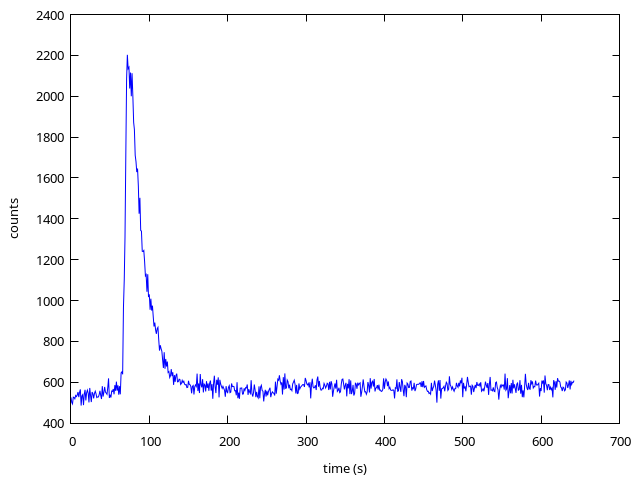

In [22]:
plot(gtis[:XTI][1].times, gtis[:XTI][1].counts; xlabel="time (s)", ylabel="counts");

Alternatively, we can look at a NuSTAR observation just as easily:

In [23]:
JAXTAM.download(:nustar, "90302319006");

INFO: Loading /media/robert/HVS1/heasrac/nustar/master.jld2
INFO: heasarc.gsfc.nasa.gov:/nustar/.nustar_archive/90302319006 --> /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006


`lftp heasarc.gsfc.nasa.gov -e 'mirror "/nustar/.nustar_archive/90302319006" "/media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006" --parallel=10 --only-newer && exit'`


In [24]:
JAXTAM.read_cl(:nustar, "90302319006");

INFO: Loading /media/robert/HVS1/heasrac/nustar/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nustar/append.jld2
INFO: Found: /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/event_cl/nu90302319006A01_cl.evt.gz
INFO: Found: /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/event_cl/nu90302319006B01_cl.evt.gz
INFO: Found 2 file(s) for 90302319006


INFO: Loading /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/event_cl/nu90302319006A01_cl.evt.gz


INFO: Loading /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/event_cl/nu90302319006B01_cl.evt.gz
INFO: Saving FPMB
INFO: Saving FPMA


In [25]:
JAXTAM.calibrate(:nustar, "90302319006");

INFO: Loading /media/robert/HVS1/heasrac/nustar/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nustar/append.jld2
INFO: Loading EVENTS for 90302319006 from /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/JAXTAM/
INFO: Loading FPMA EVENTS
INFO: Loading 90302319006: FPMA from /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/JAXTAM/
INFO: Loading 90302319006: FPMB from /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/JAXTAM/
INFO: Saving FPMA CALIB energy
INFO: Loading FPMB EVENTS
INFO: Loading 90302319006: FPMA from /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/JAXTAM/
INFO: Loading 90302319006: FPMB from /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/JAXTAM/
INFO: Saving FPMB CALIB energy


In [26]:
JAXTAM.lcurve(:nustar, "90302319006", 1);

INFO: Loading /media/robert/HVS1/heasrac/nustar/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nustar/append.jld2
INFO: Loading CALIB 90302319006: from /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/JAXTAM/
INFO: Loading FPMA CALIB energy
INFO: Loading FPMB CALIB energy
INFO: Saving FPMA 1s lightcurve data
INFO: Saving FPMB 1s lightcurve data


In [27]:
gtis = JAXTAM.gtis(:nustar, "90302319006", 1)

INFO: Loading /media/robert/HVS1/heasrac/nustar/master.jld2
INFO: Loading /media/robert/HVS1/heasrac/nustar/append.jld2
INFO: Not all GTI metas found
INFO: Loading LC 90302319006: from /media/robert/HVS1/heasrac/nustar/nustar/nustar_archive/90302319006/JAXTAM/lc/1/
INFO: Computing FPMA GTIs
INFO: Original counts: 2222543, counts in GTI: 2213693, delta: -8850 (-0.4 %)
INFO: Saving FPMA GTIs
INFO: Computing FPMB GTIs
INFO: Original counts: 1583111, counts in GTI: 1576830, delta: -6281 (-0.4 %)
INFO: Saving FPMB GTIs


Dict{Symbol,Dict{Int64,JAXTAM.GTIData}} with 2 entries:
  :FPMB => Dict(24=>JAXTAM.GTIData(:nustar, :FPMB, "90302319006", 1.0, 24, 1066…
  :FPMA => Dict(24=>JAXTAM.GTIData(:nustar, :FPMA, "90302319006", 1.0, 24, 1066…

Where, unlike with the NICER data, the purpose of the dictionary approach to storage should be clearer. Above we see both NuSTAR instruments in the GTIs dictionary, looking at one instrument we see:

In [28]:
gtis[:FPMA]

Dict{Int64,JAXTAM.GTIData} with 5 entries:
  24 => JAXTAM.GTIData(:nustar, :FPMA, "90302319006", 1.0, 24, 10663, [280, 271…
  4  => JAXTAM.GTIData(:nustar, :FPMA, "90302319006", 1.0, 4, 7439, [265, 274, …
  2  => JAXTAM.GTIData(:nustar, :FPMA, "90302319006", 1.0, 2, 4833, [251, 235, …
  11 => JAXTAM.GTIData(:nustar, :FPMA, "90302319006", 1.0, 11, 10637, [268, 270…
  1  => JAXTAM.GTIData(:nustar, :FPMA, "90302319006", 1.0, 1, 1, [246, 256, 268…

Some simple analysis can be performed elegantly with this approach:

In [29]:
[sum(gti.counts) for gti in values(gtis[:FPMA])]

5-element Array{Int64,1}:
 736094
 174250
 687872
   4217
 611260

Or even:

In [30]:
[sum(gti.counts)/gti.times[end] for gti in values(gtis[:FPMA])]

5-element Array{Float64,1}:
 263.55 
 265.625
 264.668
 281.133
 266.344

So, we see a roughly constant count rate. Now:

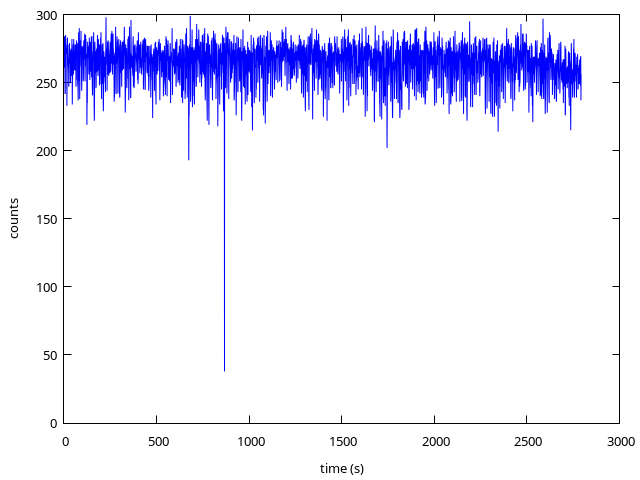

In [31]:
plot(gtis[:FPMA][24].times, gtis[:FPMA][24].counts; xlabel="time (s)", ylabel="counts");

For some basic timing analysis:

In [35]:
using DSP

In [37]:
gti_fft   = abs.(rfft(gtis[:FPMA][24].counts));
gti_fft_t = DSP.Util.rfftfreq(length(gtis[:FPMA][24].counts), 1/gtis[:FPMA][24].bin_time);

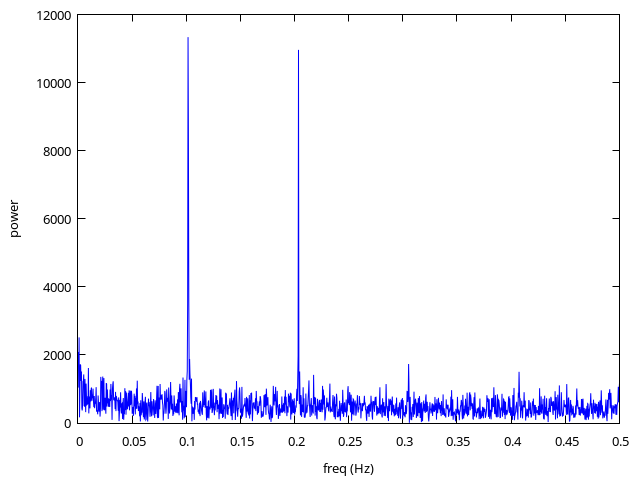

In [48]:
plot(Array(gti_fft_t)[2:end], gti_fft[2:end]; xlabel="freq (Hz)", ylabel="power");

FFT functions are still being implemented.